In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm

### 1D Ising model with 2 sites and hopping term

In [2]:
## Physical quantaties
J = 0.5
h = 1

## Gates
Z = np.array([[1,0],[0,-1]])
X = np.array([[0,1],[1,0]])
I = np.identity(2)

## States
state_0 = np.array([1,0])
state_1 = np.array([0,1])

state_0a = np.kron(state_0, state_0)
state_0b = np.kron(state_0, state_1)
state_1a = np.kron(state_1, state_0)
state_1b = np.kron(state_1, state_1)

## Projections
proj_0a = np.outer(state_0a, state_0a)
proj_0b = np.outer(state_0b, state_0b)
proj_1a = np.outer(state_1a, state_1a)
proj_1b = np.outer(state_1b, state_1b)

## Hamiltonian
H = 'J * np.kron(Z, Z) + h * np.kron(X, I) + h * np.kron(I, X)'

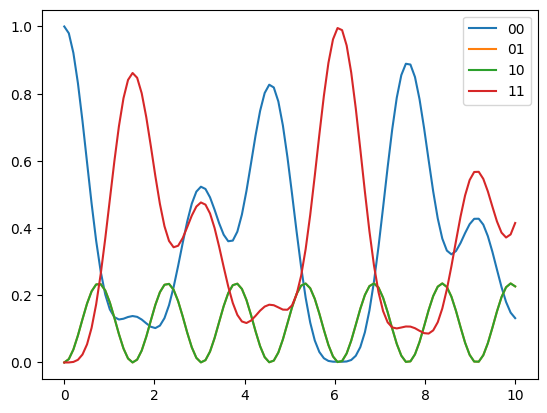

In [3]:
## Exact time evolution
H_exact = eval(H)
initial_state = state_0a

t_max = 10
dt = 0.1
t = np.linspace(0, t_max, int(t_max/dt))
t = t[...,None, None]                        #reshape to be able to broadcast into H

U_exact = expm(-1j*H_exact*t)

psi_t = U_exact @ initial_state

probs = np.abs(psi_t)**2

exact_0a = np.linalg.norm(proj_0a @ psi_t[...,None], axis=1)**2
exact_0b = np.linalg.norm(proj_0b @ psi_t[...,None], axis=1)**2
exact_1a = np.linalg.norm(proj_1a @ psi_t[...,None], axis=1)**2
exact_1b = np.linalg.norm(proj_1b @ psi_t[...,None], axis=1)**2

plt.plot(t[:,0], exact_0a, label = '00')
plt.plot(t[:,0], exact_0b, label = '01')
plt.plot(t[:,0], exact_1a, label = '10')
plt.plot(t[:,0], exact_1b, label = '11')

plt.legend()

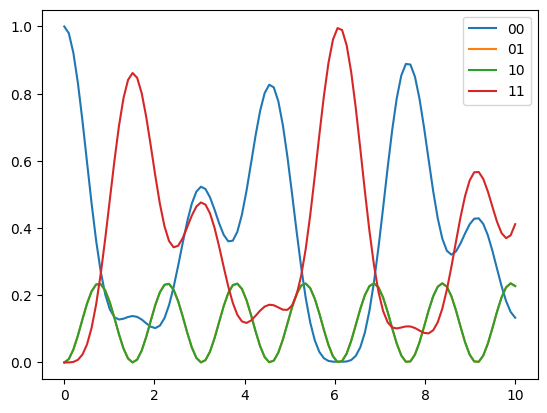

In [4]:
## Trotterization
initial_state = state_0a                     #Set initial state equal to 00

n = 100                                        #number of Trotter steps
t_max = 10
dt = 0.1
t = np.linspace(0, t_max, int(t_max/dt))
t = t[...,None, None]                        #reshape to be able to broadcast into H

# Split the Hamiltonian and create unitaries
for i, term in enumerate(H.split('+')):
    globals()[f"U_{i}"] = expm(-1j*eval(term)*t/n)

U_t = (U_0 @ U_1 @ U_2)
#Repeat for number of Trotter steps
for i in range(n - 1):
    U_t = U_t @ (U_0 @ U_1 @ U_2)

psi_t = U_t @ initial_state

trotter_0a = np.linalg.norm(proj_0a @ psi_t[...,None], axis=1)**2
trotter_0b = np.linalg.norm(proj_0b @ psi_t[...,None], axis=1)**2
trotter_1a = np.linalg.norm(proj_1a @ psi_t[...,None], axis=1)**2
trotter_1b = np.linalg.norm(proj_1b @ psi_t[...,None], axis=1)**2

plt.plot(t[:,0], trotter_0a, label = '00')
plt.plot(t[:,0], trotter_0b, label = '01')
plt.plot(t[:,0], trotter_1a, label = '10')
plt.plot(t[:,0], trotter_1b, label = '11')

plt.legend()

In [5]:
np.mean(1/4 * np.trace(U_t.conjugate().transpose(0,2,1) @ U_exact, axis1 = 1, axis2 = 2))

np.complex128(0.9998944541350477-1.2394599235854287e-17j)

In [6]:
len(U_t[0])

4

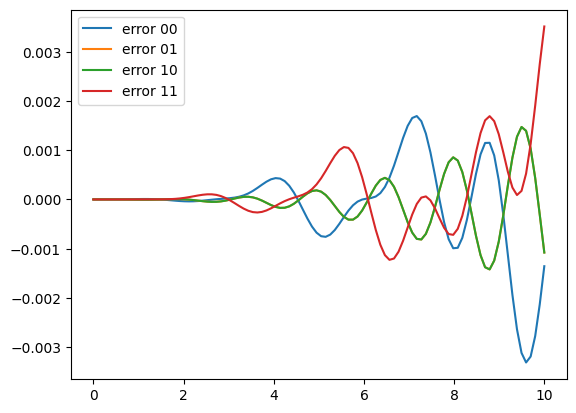

In [7]:
plt.plot(t[:,0], exact_0a - trotter_0a, label = 'error 00')
plt.plot(t[:,0], exact_0b - trotter_0b, label = 'error 01')
plt.plot(t[:,0], exact_1a - trotter_1a, label = 'error 10')
plt.plot(t[:,0], exact_1b - trotter_1b, label = 'error 11')

plt.legend()

In [8]:
## Physical quantaties
J = 0.5
g = 1
h = 1

#Ising Hamiltonian for 2 sites
hamiltonian = 'J * np.kron(Z, Z) + g * np.kron(Z, I) + g * np.kron(I, Z) + h * np.kron(X, I) + h * np.kron(I, X)'

initial_state = state_0a   

t = np.linspace(0, t_max, int(t_max/dt))
t = t[...,None, None]                        #reshape to be able to broadcast into H
time = t[:,0]
#trotter time evolution
trotter_steps = 25
dt = 0.1

H_terms = [eval(term) for term in hamiltonian.split('+')]
U = expm(-1j * H_terms[-1] * t / (trotter_steps))
for terms in H_terms[:-1]:
    U = expm(-1j * terms * t / (2 * trotter_steps)) @ U @ expm(-1j * terms * t / (2 * trotter_steps))

U_t = U
for i in range(trotter_steps-1):
    U_t = U_t @ U

psi_t = U_t @ initial_state

probabilities_trotter2 = np.abs(psi_t)**2

#exact time evolution
H_exact = eval(hamiltonian)
        
U_exact = expm(-1j*H_exact*t)
        
psi_exact = U_exact @ initial_state
        
probabilities_exact = np.abs(psi_exact)**2


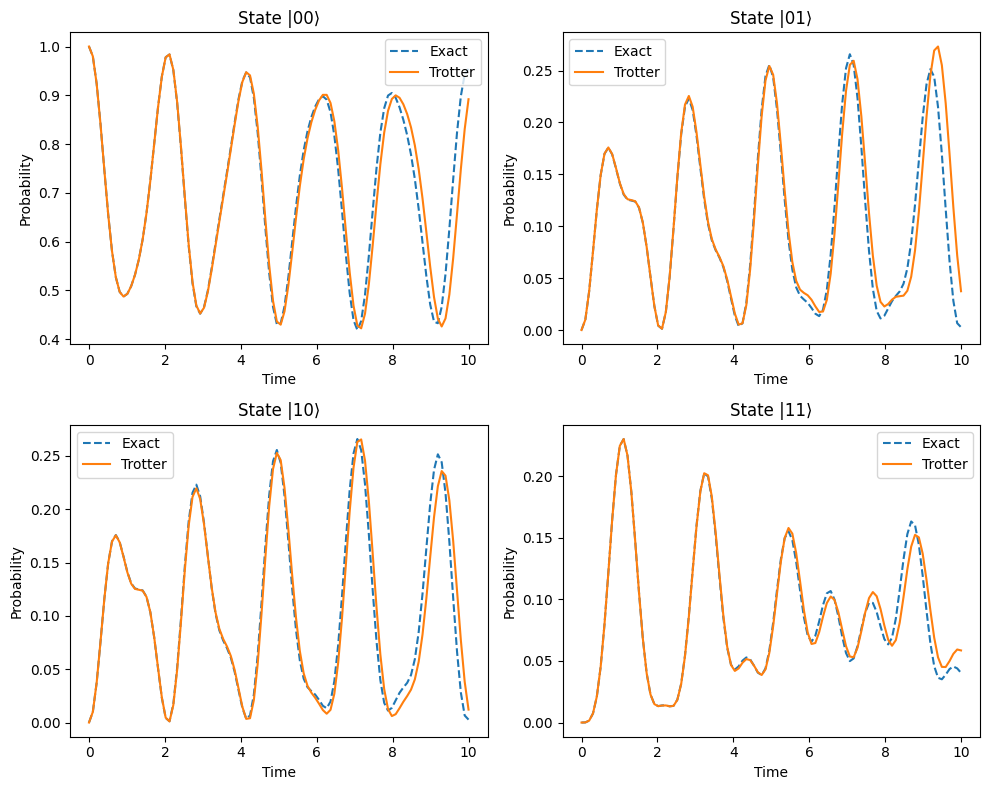

In [9]:
#plotting
fig, axes = plt.subplots(2, 2, figsize=(10, 8))  
axes = axes.flatten()  #So we can index axes[0]..axes[3]

states = [format(i, f"0{2}b") for i in range(2**2)]  #Create a bit string for given state

for i, state in enumerate(states):
    ax = axes[i]
    ax.plot(time, probabilities_exact[:, i], label="Exact", linestyle="--")
    ax.plot(time, probabilities_trotter2[:, i], label="Trotter")
    ax.set_title(f"State |{state}⟩")
    ax.set_xlabel("Time")
    ax.set_ylabel("Probability")
    ax.legend()

plt.tight_layout()
plt.show()

In [10]:
## Physical quantaties
J = 0.5
g = 1
h = 1

#Ising Hamiltonian for 2 sites
hamiltonian = 'J * np.kron(Z, Z) + g * np.kron(Z, I) + g * np.kron(I, Z) + h * np.kron(X, I) + h * np.kron(I, X)'

initial_state = state_0a

times = np.linspace(0, t_max, int(t_max/dt))
#trotter time evolution
trotter_steps = 25
dt = 0.1
small_dt = dt / trotter_steps

def build_trotter_2_step(dt):
    H_terms = [eval(term) for term in hamiltonian.split('+')]
    U = np.eye(H_terms[0].shape[0], dtype=complex)
    for terms in H_terms[:-1]:
        U = expm(-1j * terms * dt / 2) @ U
    U = expm(-1j * H_terms[-1] * dt) @ U
    for terms in reversed(H_terms[:-1]):
        U = expm(-1j * terms * dt / 2) @ U
    return U

U_t_list = []
psi_t_list = []
for T in times:
    U_t = np.eye(H_terms[0].shape[0], dtype=np.complex128)
    steps_needed = int(T/small_dt)
    for _ in range(steps_needed):
        U_t = build_trotter_2_step(small_dt) @ U_t
    psi_t = U_t @ initial_state
    U_t_list.append(U_t)
    psi_t_list.append(psi_t)

psi_t2 = np.array(psi_t_list)
U_t2 = np.array(U_t_list)
probabilities_trotter2 = np.abs(psi_t2)**2

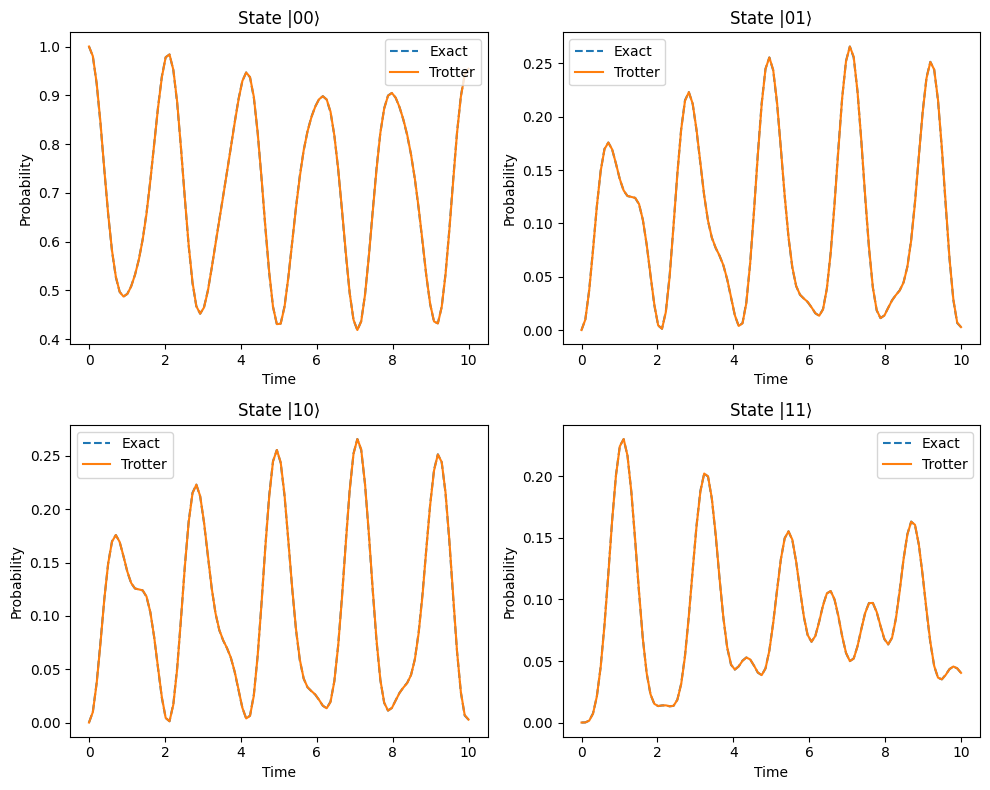

In [11]:
#plotting
fig, axes = plt.subplots(2, 2, figsize=(10, 8))  
axes = axes.flatten()  #So we can index axes[0]..axes[3]

states = [format(i, f"0{2}b") for i in range(2**2)]  #Create a bit string for given state

for i, state in enumerate(states):
    ax = axes[i]
    ax.plot(time, probabilities_exact[:, i], label="Exact", linestyle="--")
    ax.plot(time, probabilities_trotter2[:, i], label="Trotter")
    ax.set_title(f"State |{state}⟩")
    ax.set_xlabel("Time")
    ax.set_ylabel("Probability")
    ax.legend()

plt.tight_layout()
plt.show()

In [12]:
class QuantumCircuit:
    def __init__(self, n):
        '''
        Initialises a quantum circuit in the 0 state with n qubits
        '''
        self.n = n
        self.state = np.zeros(2**n, dtype=np.complex128)
        self.state[0] = 1.0
        self.gates_history = []    
        
    def second_trotter(self, hamiltonian, trotter_steps=1000, t_max=10, dt=0.1):
        '''
        Calculates the Trotter approximation to time evolution (second order) 
        for H = H1 + H2 + ... + Hn
        '''
        from scipy.linalg import expm
        import numpy as np
    
        initial_state = self.state
    
        times = np.linspace(0, t_max, int(t_max/dt))
    
        # Split Hamiltonian into matrix terms
        H_terms = [eval(term) for term in hamiltonian.split('+')]
    
        def trotter_step(dt):
            """One second-order Trotter step for small time dt."""
            # Forward half-steps for first n-1 terms
            U = np.eye(H_terms[0].shape[0], dtype=complex)
            for H in H_terms[:-1]:
                U = expm(-1j * H * dt / 2) @ U
            # Full step for last term
            U = expm(-1j * H_terms[-1] * dt) @ U
            # Backward half-steps
            for H in reversed(H_terms[:-1]):
                U = expm(-1j * H * dt / 2) @ U
            return U
    
        # Δt for each trotter step
        small_dt = dt / trotter_steps
    
        U_t_list = []
        psi_t_list = []
        for T in times:
            # Build U(T) by repeating small steps
            U_total = np.eye(H_terms[0].shape[0], dtype=complex)
            steps_needed = int(T / small_dt)
            for _ in range(steps_needed):
                U_total = trotter_step(small_dt) @ U_total
            psi_t = U_total @ initial_state
            U_t_list.append(U_total)
            psi_t_list.append(psi_t)
    
        probabilities = np.abs(np.array(psi_t_list))**2
        return probabilities, times, np.array(psi_t_list), np.array(U_t_list)

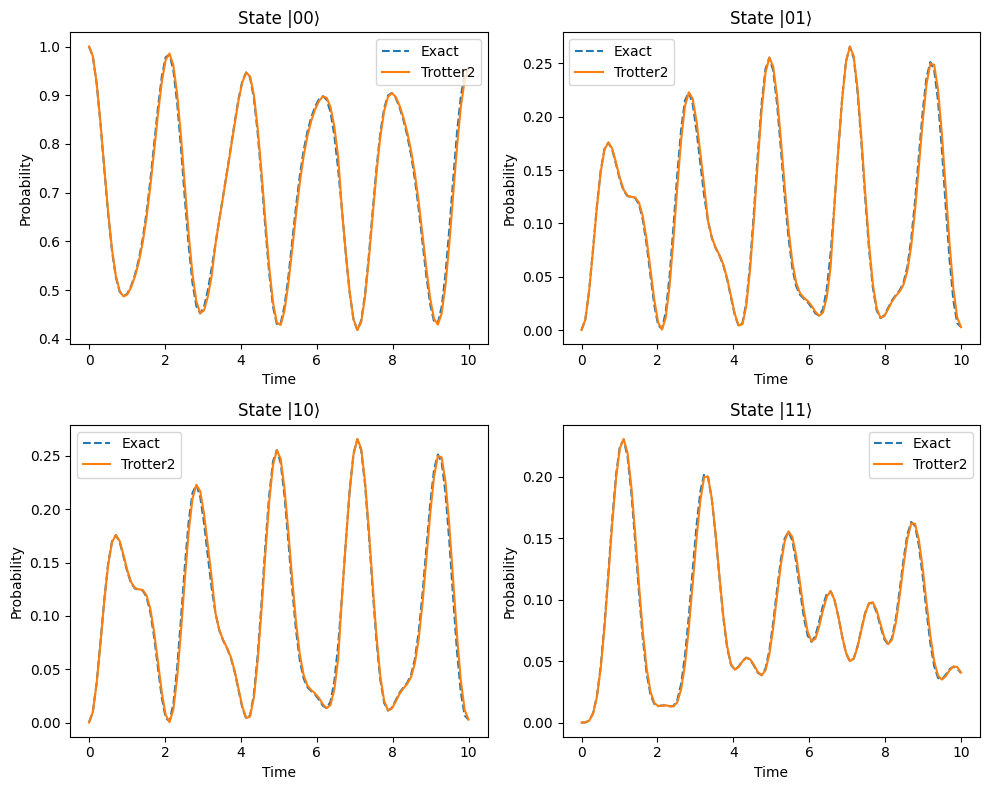

In [13]:
## Physical quantaties
J = 0.5
g = 1
h = 1

#Ising Hamiltonian for 2 sites
hamiltonian = 'J * np.kron(Z, Z) + g * np.kron(Z, I) + g * np.kron(I, Z) + h * np.kron(X, I) + h * np.kron(I, X)'
#initial state
n = 2
qc = QuantumCircuit(n)

#max time
t_max = 10
dt = 0.1

#exact time evolution
#probabilities_exact, time, psi_exact, U_exact = qc.exact_time_evo(hamiltonian, t_max = t_max, dt = dt)
#probabilities_exact1, time, psi_exact1, U_exact1 = qc.exact_time_evo1(hamiltonian, t_max = t_max, dt = dt)

#trotter time evolution
trotter_steps = 3
#probalitities_trotter, time, psi_trotter, U_trotter = qc.trotter_time_evo(hamiltonian, trotter_steps = trotter_steps, t_max = t_max, dt = dt)
#probalitities_trotter1, time, psi_trotter1, U_trotter1 = qc.trotter_time_evo1(hamiltonian, trotter_steps = trotter_steps, t_max = t_max, dt = dt)
probalitities_trotter2, time, psi_trotter2, U_trotter2 = qc.second_trotter(hamiltonian, trotter_steps = trotter_steps, t_max = t_max, dt = dt)

#plotting
fig, axes = plt.subplots(n, n, figsize=(10, 8))  
axes = axes.flatten()  #So we can index axes[0]..axes[3]

states = [format(i, f"0{n}b") for i in range(2**n)]  #Create a bit string for given state

for i, state in enumerate(states):
    ax = axes[i]
    ax.plot(time, probabilities_exact[:, i], label="Exact", linestyle="--")
    #ax.plot(time, probabilities_exact1[:, i], label="Exact1")
    #ax.plot(time, probalitities_trotter[:, i], label="Trotter")
    #ax.plot(time, probalitities_trotter1[:, i], label="Trotter1")
    ax.plot(time, probalitities_trotter2[:, i], label="Trotter2")
    ax.set_title(f"State |{state}⟩")
    ax.set_xlabel("Time")
    ax.set_ylabel("Probability")
    ax.legend()

plt.tight_layout()
plt.show()

In [14]:
#Trotter steps to try
trotter_steps = np.linspace(1, 100, 100)

## Physical quantaties
J = 0.5
g = 1
h = 1

#Ising Hamiltonian for 2 sites
hamiltonian = 'J * np.kron(Z, Z) + g * np.kron(Z, I) + g * np.kron(I, Z) + h * np.kron(X, I) + h * np.kron(I, X)'

#number of qubits
n = 2

#Setting up an initial state
qc = QuantumCircuit(n)

#max time
t_max = 10
dt = 0.1

#exact time evolution
probabilities_exact, time, psi_exact, U_exact = qc.exact_time_evo(hamiltonian, t_max = t_max, dt = dt)

#trotter time evolution
fidelity_arr2 = []
norm_arr2 = []
for step in trotter_steps:
    probalitities_trotter, time, psi_trotter2, U_trotter2 = qc.second_trotter(hamiltonian, trotter_steps = int(step), t_max = t_max, dt = dt)
    fidelity_arr2.append(fidelity_func(psi_exact = psi_exact, psi_trotter = psi_trotter2)[-1])
    norm_arr2.append(operator_norm(U_trotter = U_trotter2, U_exact = U_exact)[-1])

AttributeError: 'QuantumCircuit' object has no attribute 'exact_time_evo'

### Measurement for quantum circuit class

In [ ]:
def measure(self, n):
        '''
        Measure qubit n in z basis
        '''
        self.gates_history.append(['M', n]) 
        I = np.identity(2)                #identity
        zero = np.array([1, 0])           #zero state
        one = np.array([0,1])             #one state
        rng = np.random.default_rng()     #setup random number generator
        q = int(np.log2(len(self.state))) #number of qubits

        #projector onto the 0 state 
        projector_0 = kron_all(
            gate_pow(I, n), 
            np.outer(zero, zero), 
            gate_pow(I, q - n - 1)
        )

        #projector onto the 1 state 
        projector_1 = kron_all(
            gate_pow(I, n),
            np.outer(one, one),
            gate_pow(I, q - n - 1)
            )

        state_0 = projector_0 @ self.state
        state_1 = projector_1 @ self.state

        p = [np.linalg.norm(state_0) ** 2, np.linalg.norm(state_1) ** 2]
        
        output = rng.choice((0,1), p = p)
        if output:
            self.state = state_1 / np.sqrt(p[1])
        else:
            self.state = state_0 / np.sqrt(p[0])
        print(f"Qubit {n} is measured to be {output}, congratulations!")
        return output

    def measure_all(self):
        '''
        Measures all qubits and give the probability of getting every outcome
        '''
        probabilities = np.abs(self.state)**2

        rng = np.random.default_rng()     #setup random number generator
        result = rng.choice(len(self.state), p = probabilities)
        
        self.state = np.zeros_like(self.state)
        self.state[result] = 1.0

        # Reverse the bitstring so qubit 0 is most significant
        bitstring = format(result, f"0{self.n}b")
        bitstring = bitstring[::-1]  # reverse
        
        return probabilities, int(bitstring, 2)

    def draw(self):
        '''
        Print a simple ASCII representation of the circuit
        '''
        # Initialize empty lines for each qubit
        lines = [["|0>"] for _ in range(self.n)]

        for name, n in self.gates_history:
            for i in range(self.n):
                if i is n:
                    lines[i].append(f"-[{name}]-")
                else:
                    lines[i].append("------")
        
        # Join and print each line
        for i in range(self.n):
            print(f"q{i} : " + "".join(lines[i]))

In [25]:
Z = np.array([[1,0],[0,-1]])
X = np.array([[0,1],[1,0]])
Y = np.array([[0,-1j],[1j,0]])
H = 1/np.sqrt(2) * np.array([[1,1],[1,-1]])
S = np.array([[1,0],[0,1j]])
I = np.identity(2)
CNOT = np.array([[1,0,0,0],[0,1,0,0],[0,0,0,1],[0,0,1,0]])
def R_Z(theta):
    return np.array([[np.exp(1j*theta/2),0],[0,np.exp(-1j*theta/2)]])

print(expm(-1j*Z))

[[0.54030231-0.84147098j 0.        +0.j        ]
 [0.        +0.j         0.54030231+0.84147098j]]


In [26]:
## Physical quantaties
J = 0.5
g = 1
h = 1

#Ising Hamiltonian for 2 sites
hamiltonian = 'J * np.kron(Z, Z) + g * np.kron(Z, I) + g * np.kron(I, Z) + h * np.kron(X, I) + h * np.kron(I, X)'

H_terms = [term for term in hamiltonian.split('+')]
H_prods = [prod.split('*') for prod in H_terms]
coeffs = [coeff[0] for coeff in H_prods]
paulis = [pauli[1] for pauli in H_prods]


print(H_terms)
print(H_prods)
'Z, I' in H_prods[1][1]

['J * np.kron(Z, Z) ', ' g * np.kron(Z, I) ', ' g * np.kron(I, Z) ', ' h * np.kron(X, I) ', ' h * np.kron(I, X)']
[['J ', ' np.kron(Z, Z) '], [' g ', ' np.kron(Z, I) '], [' g ', ' np.kron(I, Z) '], [' h ', ' np.kron(X, I) '], [' h ', ' np.kron(I, X)']]


True

In [108]:
#First order Trotter
t_max = 10
dt = 0.1
t = np.linspace(0, t_max, int(t_max/dt))
t = t[...,None, None]                        #reshape to be able to broadcast into H

trotter_steps = 50

gate_count = {'CNOT': 0, 'R_z': 0, 'H': 0}

H_terms = [term for term in hamiltonian.split('+')]
H_prods = [prod.split('*') for prod in H_terms]

U_t = np.identity(eval(H_terms[0]).shape[0], dtype=np.complex128)
for _ in range(trotter_steps):
    U = np.identity(eval(H_terms[0]).shape[0], dtype=np.complex128)
    for i in H_prods:
        Rz_matrices = np.zeros((100, 2, 2), dtype=complex)
        Rz_matrices[:,0,0] = np.exp(-1j * eval(i[0]) / trotter_steps * t[:,0,0])
        Rz_matrices[:,1,1] = np.exp(1j * eval(i[0]) / trotter_steps * t[:,0,0])
        if ('Z, Z' in i[1]):
            U = U @ CNOT @ np.kron(I,Rz_matrices) @ CNOT
            gate_count['CNOT'] += 2
            gate_count['R_z'] += 1
        if ('Z, I' in i[1]):
            U = U @ np.kron(Rz_matrices, I)
            gate_count['R_z'] += 1
        if ('I, Z' in i[1]):
            U = U @ np.kron(I, Rz_matrices)
            gate_count['R_z'] += 1
        if ('X, I' in i[1]):
            U = U @ np.kron(H,I) @ np.kron(Rz_matrices, I) @ np.kron(H,I)
            gate_count['H'] += 2
            gate_count['R_z'] += 1
        if ('I, X' in i[1]):
            U = U @ np.kron(I, H) @ np.kron(I, Rz_matrices) @ np.kron(I, H)
            gate_count['H'] += 2
            gate_count['R_z'] += 1
    U_t = U @ U_t
    

U_exact_trotter = np.identity(eval(H_terms[0]).shape[0], dtype=np.complex128)
for terms in H_terms:
    U_exact_trotter = U_exact_trotter @ expm(-1j * eval(terms) / trotter_steps * t)
    
U_exact_t = U_exact_trotter
for _ in range(trotter_steps):
    U_exact_t = U_exact_trotter @ U_exact_t

In [109]:
np.allclose(U, U_exact_trotter)

True

In [113]:
U_t - U_exact_t

array([[[-1.66533454e-14+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
         -1.11855716e-15+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j],
        [ 0.00000000e+00+0.00000000e+00j,
         -1.66533454e-14+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
         -1.11855716e-15+0.00000000e+00j],
        [-1.11855716e-15+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
         -1.66533454e-14+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j],
        [ 0.00000000e+00+0.00000000e+00j,
         -1.11855716e-15+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
         -1.66533454e-14+0.00000000e+00j]],

       [[ 1.67185152e-03+4.79380119e-03j,
          4.10561862e-04+1.92250587e-03j,
          4.10561862e-04+1.92250587e-03j,
          4.06107152e-04-1.20073413e-05j],
        [ 3.98902843e-04+1.92495880e-03j,
          4.57653875e-04-9.98275617e-04j,
          4.06150865e-04+1.05114779e-05j,
         -4.05604928e-04+1.

In [111]:
np.allclose(U_exact_t,U_t)

False

In [75]:
gate_count

{'CNOT': 2, 'R_z': 5, 'H': 4}

In [97]:
#Second order Trotter
t_max = 10
dt = 0.1
t = np.linspace(0, t_max, int(t_max/dt))
t = t[...,None, None]                        #reshape to be able to broadcast into H

gate_count = {'CNOT': 0, 'R_z': 0, 'H': 0}

H_terms = [term for term in hamiltonian.split('+')]
H_prods = [prod.split('*') for prod in H_terms]

Rz_matrices = np.zeros((100, 2, 2), dtype=complex)
Rz_matrices[:,0,0] = np.exp(-1j * eval(H_prods[-1][0]) * t[:,0,0])
Rz_matrices[:,1,1] = np.exp(1j * eval(H_prods[-1][0]) * t[:,0,0])

if ('Z, Z' in H_prods[-1][1]):
    print('Z, Z')
    U = CNOT @ np.kron(I,Rz_matrices) @ CNOT
    gate_count['CNOT'] += 2
    gate_count['R_z'] += 1
elif ('Z, I' in H_prods[-1][1]):
    print('Z, I')
    U = np.kron(Rz_matrices, I)
    gate_count['R_z'] += 1
elif ('I, Z' in H_prods[-1][1]):
    print('I, Z')
    U = np.kron(I, Rz_matrices)
    gate_count['R_z'] += 1
elif ('X, I' in H_prods[-1][1]):
    print('X, I')
    U = np.kron(H,I) @ np.kron(Rz_matrices, I) @ np.kron(H,I)
    gate_count['H'] += 2
    gate_count['R_z'] += 1
elif ('I, X' in H_prods[-1][1]):
    print('I, X')
    U = np.kron(I, H) @ np.kron(I, Rz_matrices) @ np.kron(I, H)
    gate_count['H'] += 2
    gate_count['R_z'] += 1

for i in reversed(H_prods[:-1]):
    Rz_matrices = np.zeros((100, 2, 2), dtype=complex)
    Rz_matrices[:,0,0] = np.exp(-1j * eval(i[0])/2 * t[:,0,0])
    Rz_matrices[:,1,1] = np.exp(1j * eval(i[0])/2 * t[:,0,0])
    if ('Z, Z' in i[1]): 
        U = CNOT @ np.kron(I,Rz_matrices) @ CNOT @ U @ CNOT @ np.kron(I,Rz_matrices) @ CNOT
        gate_count['CNOT'] += 4
        gate_count['R_z'] += 2
    elif ('Z, I' in i[1]):
        U = np.kron(Rz_matrices, I) @ U @ np.kron(Rz_matrices, I)
        gate_count['R_z'] += 2
    elif ('I, Z' in i[1]):
        U = np.kron(I, Rz_matrices) @ U @ np.kron(I, Rz_matrices)
        gate_count['R_z'] += 2
    elif ('X, I' in i[1]):
        U = np.kron(H,I) @ np.kron(Rz_matrices, I) @ np.kron(H,I) @ U @ np.kron(H,I) @ np.kron(Rz_matrices, I) @ np.kron(H,I)
        gate_count['H'] += 4
        gate_count['R_z'] += 2
    elif ('I, X' in i[1]):
        U = np.kron(I, H) @ np.kron(I, Rz_matrices) @ np.kron(I, H) @ U @ np.kron(I, H) @ np.kron(I, Rz_matrices) @ np.kron(I, H)
        gate_count['H'] += 4
        gate_count['R_z'] += 2


U_trot = expm(-1j * eval(H_terms[-1]) * t )
for terms in reversed(H_terms[:-1]):
    U_trot = expm(-1j * eval(terms) * t / 2) @ U_trot @ expm(-1j * eval(terms) * t / 2)

I, X


In [98]:
np.allclose(U,U_trot)

True

In [99]:
gate_count

{'CNOT': 4, 'R_z': 9, 'H': 6}